# MODELAMIENTO

Importamos librerias:

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import Lasso, SGDRegressor, Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

## ETL - DATAFRAME

In [3]:
data = pd.read_csv("D:\Dataviz\Proyecto Final\data\wind_dataset.csv")
data.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


Rellenamos los datos faltante de la temperatura con la media y los de los indices con el más repetido. 

In [4]:
coluTemp = ["T.MAX" ,"T.MIN" ,"T.MIN.G" ]
for i in coluTemp:
    print(i)
    print(data[i].mean())
coluInd = ["IND.1","IND.2"]
for i in coluTemp:
    print(i)
    print(data[i].mode())
FilterInd1 = 0.0
FilterTmax = 10.0
FilterInd =0.0
FilterTMIN = 9.0
FilterTMIN_g = 5.0
data["IND.1"].fillna(FilterInd1 , inplace = True)
data["T.MAX"].fillna(FilterTmax , inplace = True)
data["IND.2"].fillna(FilterInd , inplace = True)
data["T.MIN"].fillna(FilterTMIN , inplace = True)
data["T.MIN.G"].fillna(FilterTMIN_g , inplace = True)

T.MAX
13.339123131194354
T.MIN
6.411677966101696
T.MIN.G
2.73654650788542
T.MAX
0    10.0
dtype: float64
T.MIN
0    9.0
dtype: float64
T.MIN.G
0    5.0
dtype: float64


Descomponemos la columna ``DATE`` en sus componentes individuales

In [5]:
data['DATE'] = pd.to_datetime(data['DATE'])

data['YEAR'] = data['DATE'].dt.year
data['MONTH'] = data['DATE'].dt.month
data['DAY'] = data['DATE'].dt.day


Verificamos que no tenemos datos nulos en el Dataframe

In [6]:
data.describe()

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G,YEAR,MONTH,DAY
count,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000,6574.000000
mean,9.796834,0.391542,1.885169,0.353057,13.023699,0.460146,6.677046,2.860496,1969.500304,6.523274,15.728628
std,4.977272,1.179092,4.030529,1.123823,4.755173,1.172940,4.462681,5.438954,5.188131,3.448871,8.800335
min,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,-11.500000,-14.400000,1961.000000,1.000000,1.000000
25%,6.000000,0.000000,0.000000,0.000000,10.000000,0.000000,3.500000,-0.900000,1965.000000,4.000000,8.000000
50%,9.210000,0.000000,0.200000,0.000000,12.400000,0.000000,7.300000,3.400000,1969.500000,7.000000,16.000000
75%,12.960000,0.000000,2.000000,0.000000,16.800000,0.000000,9.600000,6.600000,1974.000000,10.000000,23.000000
max,30.370000,4.000000,67.000000,4.000000,26.800000,4.000000,18.000000,15.800000,1978.000000,12.000000,31.000000


## PREPARACIÓN DE LOS DATOS

Eliminamos las columnas que no necesitamos para el entrenamiento de nuestro modelo

In [7]:
data.drop("YEAR" ,axis =1 ,inplace =True)
data.drop("DAY" ,axis =1 ,inplace =True)
data.drop("DATE" ,axis =1 ,inplace =True)

Definimos nuestra variable objetivo

In [8]:
X = data.drop(columns=['WIND'], axis=1)   
y = data['WIND']   

Con el fin de facilitar la evaluación de los modelos con relación al error de predicción, se divide la base de datos en dos conjuntos: entrenamiento y prueba. El porcentaje asignado a cada conjunto fue de 80% y 20%

In [9]:
std = StandardScaler()
X = std.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


print('X_train shape -- ', X_train.shape)
print('y_train shape -- ', y_train.shape)
print('X_test shape -- ', X_test.shape)
print('y_test shape -- ', y_test.shape)

X_train shape --  (5259, 8)
y_train shape --  (5259,)
X_test shape --  (1315, 8)
y_test shape --  (1315,)


La metodología para seleccionar el mejor modelo lo basamos en la evaluación de cuatro aspectos:
- Valor MAE, Error absoluto medio.
- Valor MSE, Error medio cuadrado.
- Valor RMSE, Raíz del Error medio cuadrado.
- Diagrama de la dispersión de los individuos Predicciones Vs. Observaciones, respecto a la pendiente de referencia del modelo.


## Linear Regression

Preprocesamiento de los datos

In [60]:
resultados = {}
reg = Pipeline([
    ('scaler', StandardScaler()),  # Escalar las características
    ('regressor', LinearRegression())
])

Entrenamos y predeccimos nuestro modelo

In [12]:
reg.fit(X_train,y_train)
predictReg = reg.predict(X_test)
mae_reg = metrics.mean_absolute_error(y_test, predictReg)
mse_reg = metrics.mean_squared_error(y_test, predictReg)
rmse_reg = np.sqrt(metrics.mean_squared_error(y_test, predictReg))

print('MAE:', mae_reg )
print('MSE:', mse_reg)
print('RMSE:', rmse_reg)

resultados['REGL'] = {
    'MAE': mae_reg,
    'MSE': mse_reg,
    'RMSE': rmse_reg,
}

MAE: 3.7372748072899777
MSE: 21.773129396992616
RMSE: 4.666168599289208


Gráficamos las predicciones vs Dato real 

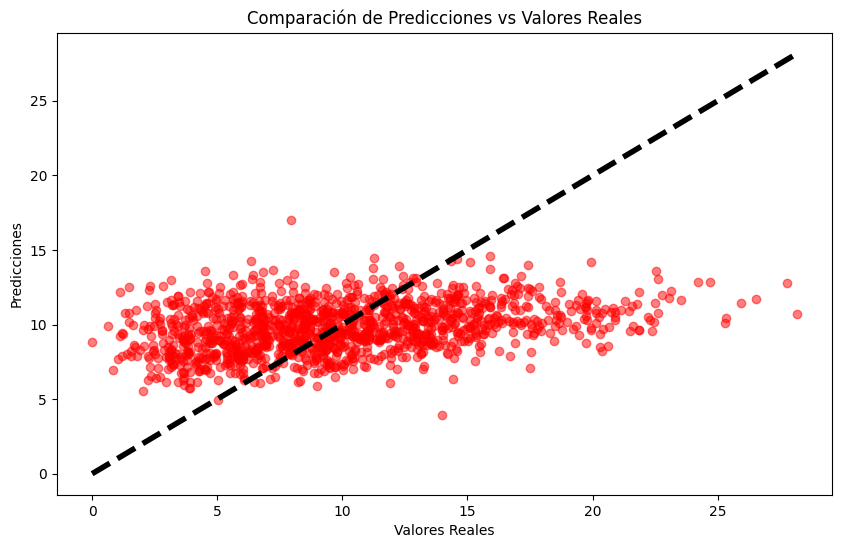

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictReg, alpha=0.5, color='red') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  
plt.title('Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

## Decision Tree

Definimos hiperparametros 

In [14]:
paramTree_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'splitter': ['best', 'random']
}

Buscamos los mejores hiperparametros para entrenar nuestro modelo

In [15]:
tree = DecisionTreeRegressor()
gridTree_search = GridSearchCV(estimator=tree, param_grid=paramTree_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

Entrenamos y predeccimos con los mejores hiperparametros encontrados

In [16]:
gridTree_search.fit(X_train, y_train)

print("Mejores parámetros:", gridTree_search.best_params_)
print("Mejor score (MSE):", gridTree_search.best_score_)

Best_tree = gridTree_search.best_estimator_
predictTree= Best_tree.predict(X_test)


mae_tree = metrics.mean_absolute_error(y_test, predictTree)
mse_tree = metrics.mean_squared_error(y_test, predictTree)
rmse_tree = np.sqrt(metrics.mean_squared_error(y_test, predictTree))

print('MAE:', mae_tree )
print('MSE:', mse_tree)
print('RMSE:', rmse_tree)

resultados['TREE'] = {
    'MAE': mae_tree,
    'MSE': mse_tree,
    'RMSE': rmse_tree,
}

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
Mejores parámetros: {'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'best'}
Mejor score (MSE): -20.380667907117832
MAE: 3.5644966089943595
MSE: 20.137537511885682
RMSE: 4.4874867701070364


Gráficamos las predicciones vs Dato real 

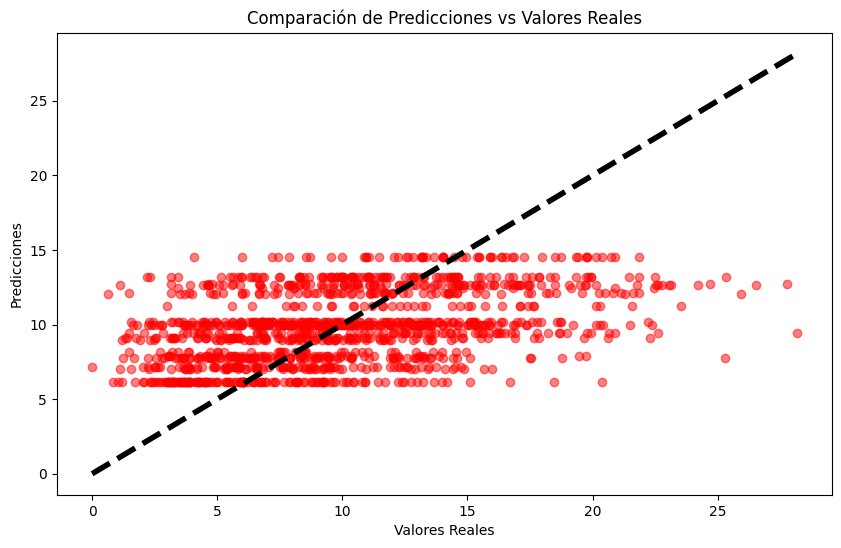

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictTree, alpha=0.5, color='red') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  
plt.title('Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

## Support vector

Definimos hiperparametros 

In [18]:
paramSvr_grid = {
    'kernel': ['linear', 'rbf'], 
    'C': [0.1, 1, 10], 
    'gamma': ['scale', 0.1],  
    'epsilon': [0.01, 0.1], 
    'degree': [2, 3]  
}


Buscamos los mejores hiperparametros para entrenar nuestro modelo

In [19]:
svr = SVR()

gridSvr_search = GridSearchCV(estimator=svr, param_grid=paramSvr_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

Entrenamos y predeccimos con los mejores hiperparametros encontrados

In [20]:
gridSvr_search.fit(X_train, y_train)

print("Mejores parámetros:", gridSvr_search.best_params_)
print("Mejor score (MSE):", gridSvr_search.best_score_)

Best_svr = gridSvr_search.best_estimator_
predictSvr= Best_svr.predict(X_test)

mae_svr = metrics.mean_absolute_error(y_test, predictSvr)
mse_svr = metrics.mean_squared_error(y_test, predictSvr)
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test, predictSvr))

print('MAE:', mae_svr )
print('MSE:', mse_svr)
print('RMSE:', rmse_svr)

resultados['SVR'] = {
    'MAE': mae_svr,
    'MSE': mse_svr,
    'RMSE': rmse_svr,
}

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor score (MSE): -19.729316957225613
MAE: 3.5031489586867224
MSE: 19.429880783498678
RMSE: 4.40793384518174


Gráficamos las predicciones vs Dato real 

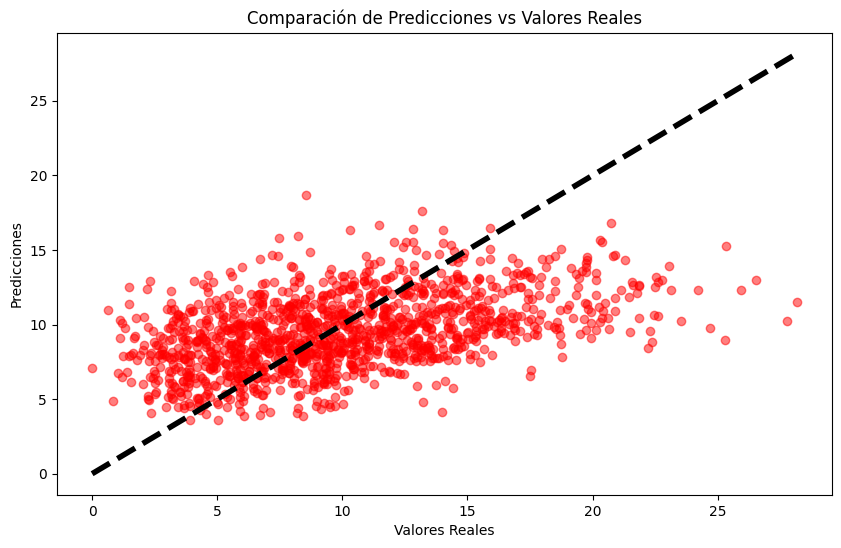

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictSvr, alpha=0.5, color='red') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  
plt.title('Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

## KNeighbors

Definimos hiperparametros 

In [22]:
paramKnn_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'p': [1, 2]
}

Buscamos los mejores hiperparametros para entrenar nuestro modelo

In [23]:
knn = KNeighborsRegressor()
gridKnn_search = GridSearchCV(estimator=knn, param_grid=paramKnn_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

Entrenamos y predeccimos con los mejores hiperparametros encontrados

In [24]:
gridKnn_search.fit(X_train, y_train)
print("Mejores parámetros:", gridKnn_search.best_params_)
print("Mejor score (MSE):", gridKnn_search.best_score_)

Best_knn = gridKnn_search.best_estimator_
predictKnn = Best_knn.predict(X_test)

mae_knn = metrics.mean_absolute_error(y_test, predictKnn)
mse_knn = metrics.mean_squared_error(y_test, predictKnn)
rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, predictKnn))

print('MAE:', mae_knn)
print('MSE:', mse_knn)
print('RMSE:', rmse_knn)

resultados['KNN'] = {
    'MAE': mae_knn,
    'MSE': mse_knn,
    'RMSE': rmse_knn,
}



Fitting 5 folds for each of 192 candidates, totalling 960 fits
Mejores parámetros: {'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
Mejor score (MSE): -20.668352912528896
MAE: 3.574144486692015
MSE: 20.669624796958175
RMSE: 4.546385904975311


Gráficamos las predicciones vs Dato real 

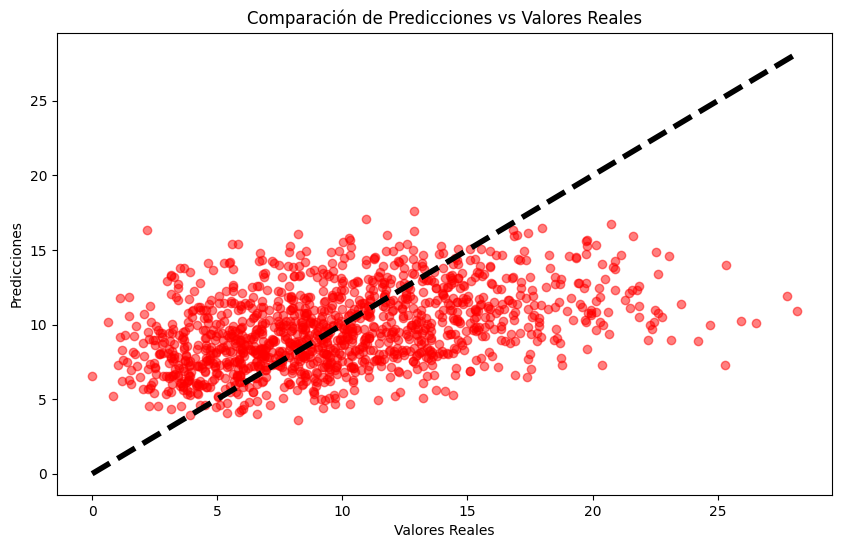

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictKnn, alpha=0.5, color='red') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  
plt.title('Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

## MLP

Definimos hiperparametros 

In [26]:
mlp = MLPRegressor(early_stopping=True, max_iter = 400)
paramMlp_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': ['auto', 64, 128]
}

Buscamos los mejores hiperparametros para entrenar nuestro modelo

In [27]:
gridMlp_search = GridSearchCV(estimator=mlp, param_grid=paramMlp_grid, 
                           scoring=make_scorer(mean_squared_error, greater_is_better=False), 
                           n_jobs=-1, cv=3, verbose=2)

Entrenamos y predeccimos con los mejores hiperparametros encontrados

In [62]:
try:
    gridMlp_search.fit(X_train, y_train)

    print("Mejores parámetros:", gridMlp_search.best_params_)
    print("Mejor score (MSE):", gridMlp_search.best_score_)

    Best_mlp = gridMlp_search.best_estimator_
    predictMlp = Best_mlp.predict(X_test)

    mae_mlp = metrics.mean_absolute_error(y_test, predictMlp)
    mse_mlp = metrics.mean_squared_error(y_test, predictMlp)
    rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test, predictMlp))

    print('MAE:', mae_mlp)
    print('MSE:', mse_mlp)
    print('RMSE:', rmse_mlp)

    resultados['MLP'] = {
        'MAE': mae_mlp,
        'MSE': mse_mlp,
        'RMSE': rmse_mlp,
    }

   
except Exception as e:
    
    with open("error_log.txt", "a") as file:
        file.write(str(e) + "\n")


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Mejores parámetros: {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 'auto', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'solver': 'sgd'}
Mejor score (MSE): -19.549900123414215
MAE: 3.5157775574952064
MSE: 19.323609900464817
RMSE: 4.395862816383698


Gráficamos las predicciones vs Dato real 

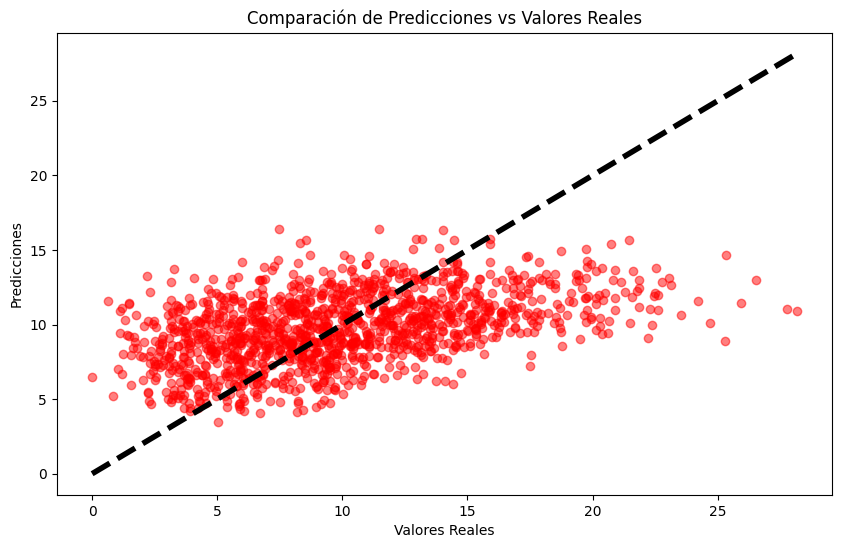

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictMlp, alpha=0.5, color='red') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  
plt.title('Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

## EVALUACIÓN

Código para separar los datos almacenados en el diccionario **resultados**

In [56]:
model_names = list(resultados.keys())
MAE = [resultados[model]['MAE'] for model in model_names]
MSE = [resultados[model]['MSE'] for model in model_names]
RMSE = [resultados[model]['RMSE'] for model in model_names]

De los resultados obtenidos evaluamos cual de ellos ofrece mejores metricas.  

In [59]:
min_mae= MAE.index(min(MAE))
min_mse= MSE.index(min(MSE))
min_rmse= RMSE.index(min(RMSE))

# Encontrar el nombre del modelo con el menor RMSE
best_model = model_names[min_rmse]

print(f"El modelo con el menor MAE es {best_model} con un MAE de {MAE[min_mae]}")
print(f"El modelo con el menor MSE es {best_model} con un MSE de {MSE[min_mse]}")
print(f"El modelo con el menor RMSE es {best_model} con un RMSE de {RMSE[min_rmse]}")

El modelo con el menor MAE es MLP con un MAE de 3.5031489586867224
El modelo con el menor MSE es MLP con un MSE de 19.323609900464817
El modelo con el menor RMSE es MLP con un RMSE de 4.395862816383698


Generamos gráfica de barra para comparar los resultados obtenidos

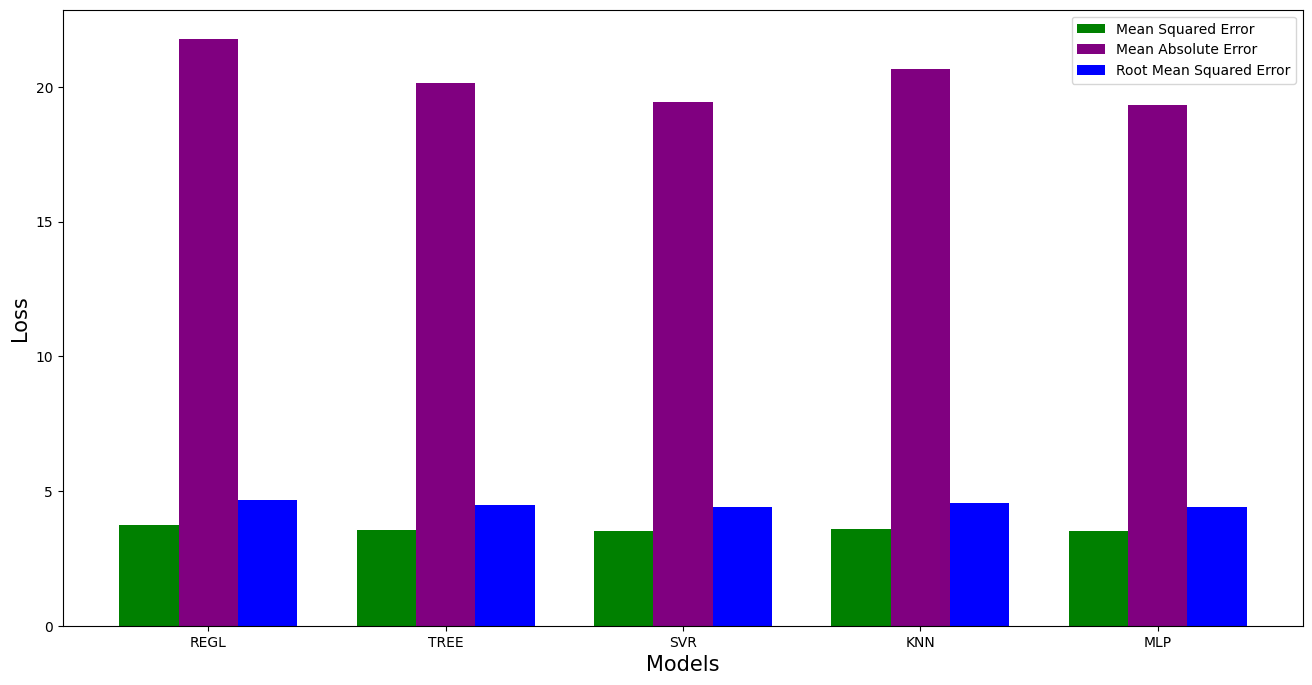

In [55]:
barwidth = 0.25

fig, ax = plt.subplots(figsize =(16, 8))
br1 = np.arange(len(MAE))
br2 = [x + barwidth for x in br1]
br3 = [x + barwidth for x in br2]

plt.bar(br1, MAE, color = 'green', width=barwidth, label='Mean Squared Error')
plt.bar(br2, MSE, color='purple', width=barwidth, label='Mean Absolute Error')
plt.bar(br3, RMSE, color='blue', width=barwidth, label='Root Mean Squared Error')

plt.xlabel("Models", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.xticks([r + barwidth for r in range(len(MAE))], model_names)

plt.legend()
plt.show()

Como conclusión, el modelo **MLPRegressor (MLP)** presentó las mejores condiciones en cada uno de
los criterios evaluados:
- MAE: 3.5 nudos
- MSE: 19.3 nudos
- RMSE: 4.39 nudos
- Diagrama de la dispersión de los individuos Predicciones Vs. Observaciones: **Menor dispersión asociada al RMSE**


## CONCLUSIONES

<div style="text-align: justify;">
Todos los modelos se sometieron a una metodología uniforme que comenzó con la estandarización de los datos para optimizar el rendimiento. Este proceso incluyó el desarrollo e integración de funciones para el entrenamiento y la transformación, así como la optimización de hiperparámetros mediante ciclos iterativos de entrenamiento, prueba y evaluación. Finalmente, se generaron predicciones para determinar el modelo más eficaz utilizando la métrica RMSE. El modelo <strong>MLPRegressor (MLP)</strong> demostró tener el mejor desempeño, alcanzando un valor inicial de 4.39 nudos.
</div>

<br>

<div style="text-align: justify;">
Se puede concluir que los valores obtenidos no son útiles para predecir de alarmas temprana de condiciones meteorológicas adversas, considerando que no representa las condiciones más críticas (valor máximo del viento).
</div>
